* Project: Loan Outcome Classification
* Author: Dmitri Kochubei
* Purpose: Correclty predict outcome of a given loan ('Paid-off'/'Charged-off')
* Created: 03.11.2020

In [300]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import , GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

#from imblearn.over_sampling import SMOTE

import scikitplot as skplt # library to plot ML metrics
# https://scikit-plot.readthedocs.io/en/stable/index.html#
import matplotlib.pyplot as plt
import pickle

#import xgboost as xgb

%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 200) #  display all the columns
pd.set_option('display.max_rows', 100) # display all the rows
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

# Loading training data

In [296]:
df = pd.read_csv('Data/train.csv')
df = df.sample(60000)
X_train = df.drop('labels',axis='columns')
y_train = df['labels'].values.ravel()

In [297]:
print(X_train.shape,y_train.shape)
print(pd.Series(y_train).value_counts(normalize=True))

(60000, 140) (60000,)
1   0.7968
0   0.2032
dtype: float64


# Loading testing data

In [298]:
df = pd.read_csv('Data/test.csv')
df = df.sample(10000)
X_test = df.drop('labels',axis='columns')
y_test = df['labels'].values.ravel()

In [299]:
print(X_test.shape,y_test.shape)
print(pd.Series(y_test).value_counts(normalize=True))

(10000, 140) (10000,)
1   0.8057
0   0.1943
dtype: float64


# Cycling through the selected models, extracting metrics

In [374]:
# GradientBoostingClassifier(n_estimators=20, learning_rate=0.001, max_depth=5, random_state=0)
# LogisticRegression(random_state=666,solver='sag',max_iter=10000,C=5,class_weight={1:0.3,0:0.7})

classifiers = [GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, 
                                          max_features=50, max_depth=15, random_state=0),
               
              LogisticRegression(random_state=666,solver='sag',max_iter=10000,C=5,
                                 class_weight={1:0.3,0:0.7}),
              
               GaussianNB()]
                
    
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc',
                                    'precision','recall',
                                    'precision score'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    
    yproba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    precision,recall,_ = precision_recall_curve(y_test,yproba)
    average_precision = average_precision_score(y_test,yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'precision':precision,
                                        'recall':recall,
                                        'precision score':average_precision}, 
                                       ignore_index=True)
    
    print('{} - DONE'.format(cls))

result_table.set_index('classifiers', inplace=True)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features=50, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) - DONE
LogisticRegression(C=5, class_weight={0: 0.7, 1: 0.3}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=666, solver='sag', tol=0.0001,
            

# Recall vs Precision curve

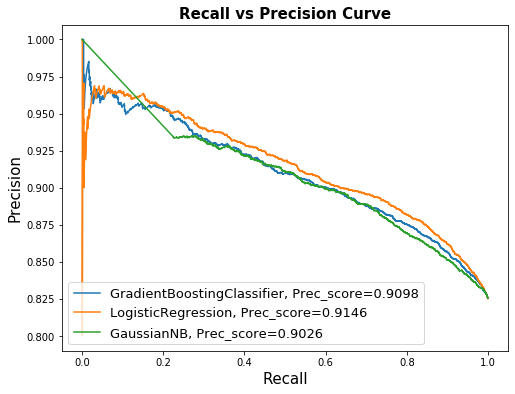

In [440]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['recall'],result_table.loc[i]['precision'],
            label="{}, Prec_score={:.4f}".format(i, result_table.loc[i]['precision score']))
    
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)

plt.title('Recall vs Precision Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower left')
plt.savefig('images/recall_precision.png')
plt.show()

# Plotting ROC

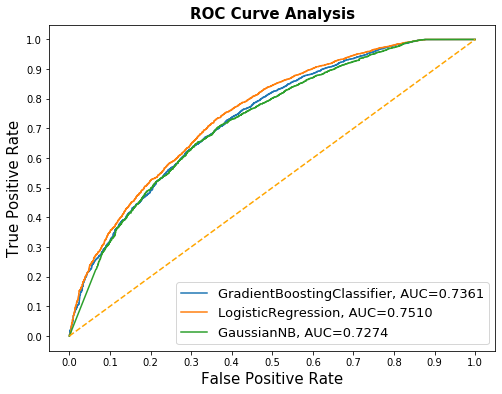

In [441]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.4f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.savefig('images/ROC.png')
plt.show()

# Classification report for every algorithm.

In [ ]:
for algo, name in zip(classifiers, result_table.index):
    print("############## {} ##############".format(name))
    prediction = algo.predict(X_test)
    print(classification_report(y_test, prediction))

# Compromising predict_proba threshold to get a better recall score

In [ ]:
threshold = 0.9

for algo, name in zip(classifiers, result_table.index):
    print("############## {} ##############".format(name))
    predict_proba = algo.predict_proba(X_test)[:,1] >= threshold
    print(classification_report(y_test, predict_proba))

# Learning Curves

In [ ]:
for i in range(len(result_table)):
        skplt.estimators.plot_learning_curve(classifiers[i], X_train, y_train,
                                            title=result_table.index[i])
        plt.savefig('images/{}learning_curve.png'.format(result_table.index[i]))
        #plt.savefig(result_table.index[i])
fig.tight_layout()

skplt.estimators.plot_learning_curve(classifiers[0], X_train, y_train)

# Confusion matrix for best performing model.

In [ ]:
# it's not as helpful as classification report
"""
plot_confusion_matrix(classifiers[0],X_test,y_test)
plt.title('Logistic Regression')
plt.show()
"""

# GridSearchCV

In [ ]:
logreg = LogisticRegression(solver='sag',max_iter=10000)
param = {'C':[10,15,25,20]}
clf = GridSearchCV(logreg,param,scoring='precision',refit=True,cv=10)
clf.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with hyperparameter: {}'.format(clf.best_score_, clf.best_params_))

# Saving the model

In [273]:
filename = 'Models/logit_model.sav'
pickle.dump(logisticRegr, open(filename, 'wb')) 

#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))